# Exploratory/ Statistical Analysis

Here, we are observing if certain business types perform better than others. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dependencies
# Analytics
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency

# KNN Imputer
from sklearn.impute import KNNImputer

In [3]:
# Read in dataframe
df = pd.read_csv('../Resources/post_processed_bakeries.csv', index_col='Unnamed: 0')
df

,id,name,review_count,rating,phone,display_phone,price,coord_lat,coord_long,is_bakeries,is_desserts,is_icecream,is_cafe,is_donuts,is_cakeshop,is_bubbletea,is_chocolate,is_cupcakes,is_Other
0,epvSBt9LldIgyc08f8nIAw,La Bicyclette Bakery,1.098612,20.25,0,0,NaN,40.683587,-73.995090,1,0,0,0,0,0,0,0,0,0
1,-k_5NsYnKCHGTdBaqegkrw,Le Fournil,4.770685,20.25,0,0,2.0,40.727947,-73.988489,1,0,0,0,0,0,0,0,0,0
2,0kW0112jMERVjpRzWT4F7Q,La Bicyclette Bakery,4.430817,25.00,1,1,NaN,40.714400,-73.959110,1,0,0,0,0,0,0,0,0,0
3,XSwagBljEsxG2i1rq4GEAQ,Almondine Bakery,6.001415,16.00,1,1,2.0,40.703317,-73.991251,1,0,0,0,0,0,0,0,0,0
4,fPQ2eE9lm8tc87O5-GLjyA,Mille-Feuille Bakery,6.089045,20.25,1,1,2.0,40.782425,-73.981160,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,8Rg9pKvacH7cO9FLvDsX-w,Atul Bakery,0.693147,16.00,1,1,NaN,40.735909,-74.066107,1,0,0,0,0,0,0,0,0,0
6364,P-eydevPkLcST4_L6W4nvA,Roni-Sue's Chocolates,4.442651,16.00,1,1,2.0,40.720389,-73.991616,0,0,0,0,0,0,0,1,0,0
6365,powAnyWIaJ1jFgKBKgeryg,Shloimes Kosher Bakery,1.609438,16.00,1,1,NaN,40.632040,-73.984840,1,0,0,0,0,0,0,0,0,0
6366,dt5ze7syLkALVI3DQfHp_A,Loqma Cafe,2.995732,12.25,0,0,2.0,40.585861,-73.953604,0,0,0,1,0,0,0,0,0,1


In [4]:
# In the preprocessing phase, we created a normal-ish distribution for rating and review_counts. 
# We can leverage this and use it as a metric for a successful business.
# Assume success means business falls in the 50th percentile for rating and review_count, performing above median 
review_metric = np.quantile(df['review_count'], 0.50)
rating_metric = np.quantile(df['rating'], 0.50)

print(f'50th Percentile of Review Counts: \n'
      f'{review_metric} and Rating: {rating_metric}')

50th Percentile of Review Counts: 
4.394449154672439 and Rating: 16.0


# Exploratory Analysis

In [5]:
# ANOVA and Tukeys
# Filter method
category_groups = [x for x in df.columns if 'is_' in x]

def get_category_for_anova(pattern):
      return df[df[pattern] == 1][['rating', 'review_count']]

def get_all_categories_for_anova(pattern_list):
      category_dict = {}
      for cat in pattern_list:
            category_dict[cat] = get_category_for_anova(cat)
      return category_dict

In [6]:
# Get dict of dataframes
category_dict = get_all_categories_for_anova(category_groups)

# Extract columns for ANOVA
reviews_for_anova = [df['review_count'] for df in category_dict.values()]
ratings_for_anova = [df['rating'] for df in category_dict.values()]

# Perform ANOVA
fstat_review, pval_review = f_oneway(*reviews_for_anova)
fstat_rating, pval_rating = f_oneway(*ratings_for_anova)

print(f'''
      Review_count:
      f_stat: {fstat_review}
      p_val: {pval_review}
      Ratings:
      f_stat: {fstat_rating}
      p_val: {pval_rating}
      ''')


      Review_count:
      f_stat: 12.261183421692454
      p_val: 2.4055970374603845e-19
      Ratings:
      f_stat: 5.5049009103916315
      p_val: 1.469152853100447e-07
      


#### Looks like theres a significant difference in categories. Continue to Tukey's

In [7]:
# Aggregate binary encoded columns back into string. Update functions
def get_category_for_anova(pattern):
      dataframe = df[df[pattern] == 1][['rating', 'review_count']]
      dataframe['category'] = str(pattern)
      return dataframe

def get_all_categories_for_anova(pattern_list):
      category_dict = {}
      for cat in pattern_list:
            category_dict[cat] = get_category_for_anova(cat)
      return category_dict

category_dict = get_all_categories_for_anova(category_groups)

In [8]:
# Perform Tukey's 
reviews_for_tukey = pd.concat([df['review_count'] for df in category_dict.values()], axis=0)
ratings_for_tukey = pd.concat([df['rating'] for df in category_dict.values()], axis=0)
labels_for_tukey = pd.concat([df.iloc[:,2] for df in category_dict.values()], axis=0)

rating_tukey = pairwise_tukeyhsd(ratings_for_tukey, labels_for_tukey, 0.05)
review_tukey = pairwise_tukeyhsd(reviews_for_tukey, labels_for_tukey, 0.05)

In [9]:
# Interpret results
print(rating_tukey)
print(review_tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    is_Other  is_bakeries  -0.4489 0.2661 -1.0162  0.1185  False
    is_Other is_bubbletea   0.3365 0.9985  -0.981  1.6541  False
    is_Other      is_cafe  -0.3977 0.9313 -1.3052  0.5097  False
    is_Other  is_cakeshop   0.7899 0.1807  -0.142  1.7217  False
    is_Other is_chocolate   1.5511 0.2259 -0.3498   3.452  False
    is_Other  is_cupcakes   1.3776 0.0135  0.1548  2.6004   True
    is_Other  is_desserts   0.1819 0.9972 -0.4769  0.8406  False
    is_Other    is_donuts  -0.3691 0.9867 -1.4517  0.7135  False
    is_Other  is_icecream   0.0537    1.0  -0.907  1.0145  False
 is_bakeries is_bubbletea   0.7854 0.6701 -0.5241  2.0949  False
 is_bakeries      is_cafe   0.0511    1.0 -0.8445  0.9468  False
 is_bakeries  is_cakeshop   1.2387 0.0009  0.3184  2.1591   True
 is_bakeries is_chocolate

# Tukey's Results:

Ratings: 

|    group1    |    group2    | meandiff | p-adj  | lower  | upper  | reject |
|--------------|--------------|----------|--------|--------|--------|--------|
| is_bakeries  | is_cakeshop  |  1.2387  | 0.0008 | 0.3177 | 2.1598 |  True  |
| is_bakeries  | is_chocolate |    2.0   | 0.0287 | 0.1032 | 3.8967 |  True  |
| is_bakeries  | is_cupcakes  |  1.8265  | 0.0001 | 0.6114 | 3.0416 |  True  |
| is_cafe      | is_cakeshop  |  1.1876  | 0.0402 | 0.0254 | 2.3498 |  True  |
| is_cafe      | is_cupcakes  |  1.7754  | 0.0024 | 0.3687 |  3.182 |  True  |
| is_cupcakes  | is_donuts    | -1.7467  | 0.0105 | -3.2725|  -0.221|  True  |

Reviews:

|   group1     |    group2    | meandiff | p-adj  |  lower  |  upper  | reject |
|--------------|--------------|----------|--------|---------|---------|--------|
| is_bakeries  | is_cafe      |  0.4268  | 0.0147 |  0.0442 |  0.8095 |  True  |
| is_bakeries  | is_cakeshop  | -0.4409  | 0.0138 | -0.8341 | -0.0476 |  True  |
| is_cafe      | is_cakeshop  | -0.8677  |   0.0  | -1.3638 | -0.3715 |  True  |
| is_cafe      | is_cupcakes  |  -0.837  | 0.0004 | -1.4376 | -0.2365 |  True  |
| is_cafe      | is_donuts    | -0.8118  | 0.0001 |  -1.361 | -0.2626 |  True  |
| is_cakeshop  | is_coffee    |  0.9563  |   0.0  |  0.5517 |  1.3608 |  True  |
| is_cakeshop  | is_desserts  |  0.5905  | 0.0003 |  0.1721 |   1.009 |  True  |
| is_cakeshop  | is_icecream  |  0.7097  | 0.0005 |  0.1956 |  1.2239 |  True  |
| is_cupcakes  | is_desserts  |  0.5599  | 0.0332 |  0.0218 |   1.098 |  True  |
| is_cupcakes  | is_icecream  |  0.6791  | 0.0169 |  0.0636 |  1.2946 |  True  |
| is_desserts  | is_donuts    | -0.5346  |  0.015 | -1.0148 | -0.0545 |  True  |
| is_donuts    | is_icecream  |  0.6538  | 0.0091 |  0.0883 |  1.2194 |  True  |



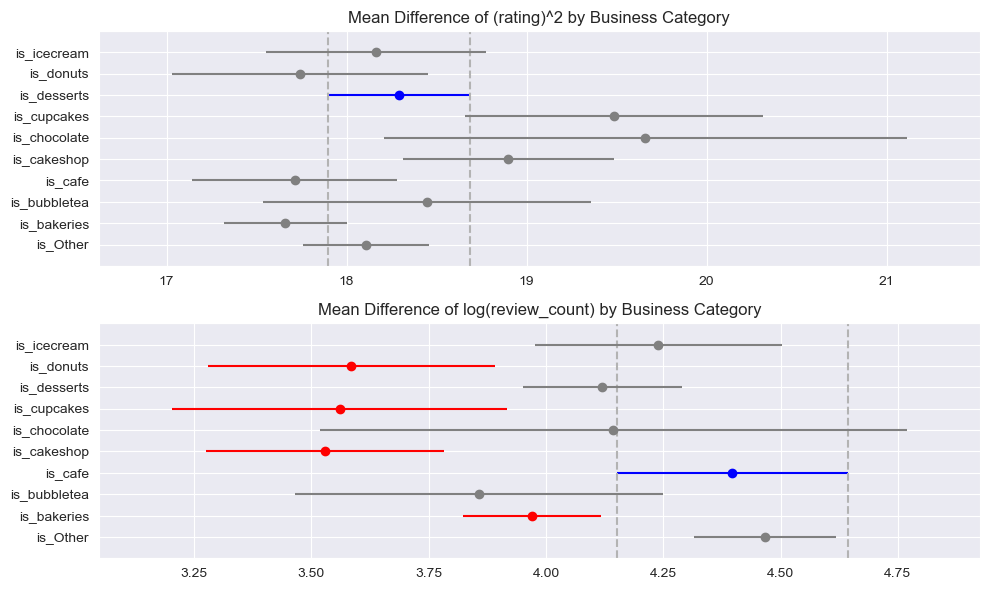

In [10]:
# Plot mean differences
fig, ax = plt.subplots(2,1)
rating_tukey.plot_simultaneous(comparison_name='is_desserts', ax=ax[0])
review_tukey.plot_simultaneous(comparison_name='is_cafe', ax=ax[1])


# Set Labels
ax[0].set_title('Mean Difference of (rating)^2 by Business Category')
ax[1].set_title('Mean Difference of log(review_count) by Business Category')
fig.tight_layout()

# Export 
fig.savefig('../Images/revised-images/meandiffs.png', format='png', dpi=150)
fig.show()

In [11]:
# Modify Function to return 'display_phone' and metrics
def get_category(pattern):
      dataframe = df[df[pattern] == 1][['display_phone', 'phone', 'rating', 'review_count']]
      dataframe['category'] = str(pattern)
      return dataframe

def get_all_categories(pattern_list):
      category_dict = {}
      for cat in pattern_list:
            category_dict[cat] = get_category(cat)
      return category_dict

category_dict = get_all_categories(category_groups)
display_phone_values = pd.concat([df[['display_phone', 'phone', 'rating']] for df in category_dict.values()], axis=0)
labels_for_display_phone = pd.concat([df.iloc[:,3] for df in category_dict.values()], axis=0)

display_phone_df = pd.concat([labels_for_display_phone, display_phone_values], axis=1)
display_phone_df

,review_count,display_phone,phone,rating
0,1.098612,0,0,20.25
1,4.770685,0,0,20.25
2,4.430817,1,1,25.00
3,6.001415,1,1,16.00
4,6.089045,1,1,20.25
...,...,...,...,...
6347,5.834811,1,1,16.00
6351,3.555348,1,1,20.25
6358,6.122493,1,1,16.00
6366,2.995732,0,0,12.25


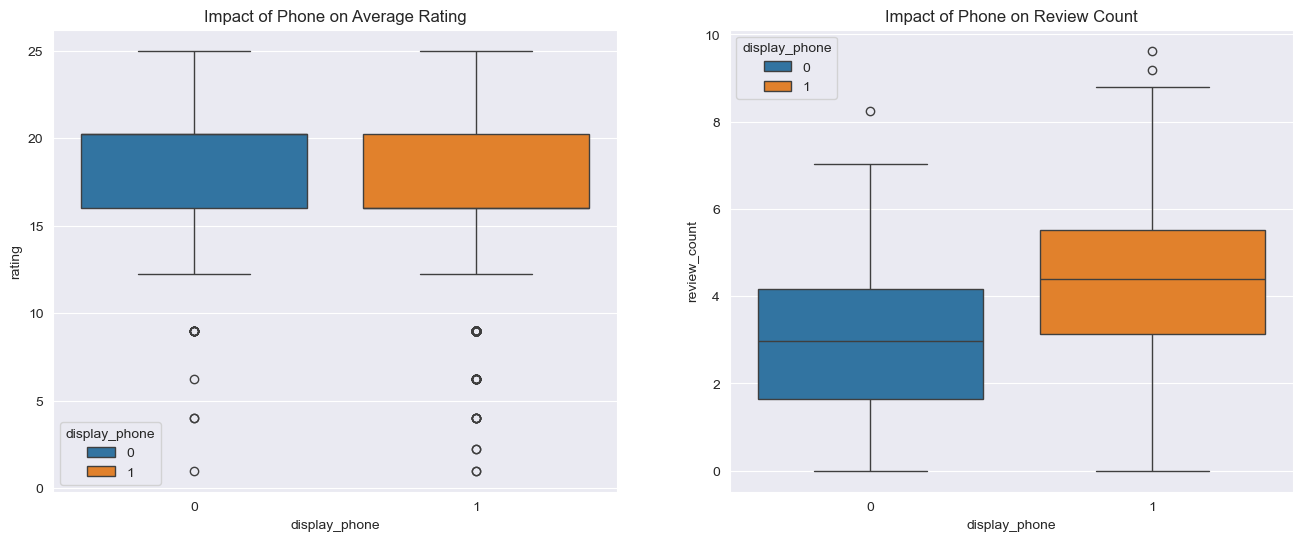

In [12]:
# Effect of Phone on rating and review count
fig, ax = plt.subplots(1,2, figsize=(16,6))
# Rating plot
sns.boxplot(data=display_phone_df, 
            x='display_phone', 
            y='rating',
            hue='display_phone', 
            ax=ax[0])\
                  .set_title("Impact of Phone on Average Rating")

# Review plot
sns.boxplot(data=display_phone_df, 
            x='display_phone',
            y='review_count', 
            hue='display_phone', 
            ax=ax[1])\
                  .set_title("Impact of Phone on Review Count")

fig.savefig('../Images/revised-images/display_phone.png', format='png', dpi=150)

# Using Imputation to fill in missing values for price

In [13]:
# Random imputation with respect to the normality of price distribution
price_ratios_df = df.price.value_counts(normalize=True, ascending=False).reset_index()
# Random imputer, preserving normality
def random_price_imputer(df, props_df):
    price_pred = np.random.choice(props_df.price, p=props_df.proportion)
    df['rand_imp_price'] = df['price'].apply(lambda x: price_pred if pd.isna(x) else x)
    return df

In [14]:
# Execute random imputer
random_price_imputer(df, price_ratios_df)
df.price.value_counts(normalize=True)

price
2.0    0.570879
1.0    0.347802
3.0    0.067033
4.0    0.014286
Name: proportion, dtype: float64

In [15]:
# Subset dataframe for imputation
df_sub = df.iloc[:, 2:19]
df_sub

,review_count,rating,phone,display_phone,price,coord_lat,coord_long,is_bakeries,is_desserts,is_icecream,is_cafe,is_donuts,is_cakeshop,is_bubbletea,is_chocolate,is_cupcakes,is_Other
0,1.098612,20.25,0,0,NaN,40.683587,-73.995090,1,0,0,0,0,0,0,0,0,0
1,4.770685,20.25,0,0,2.0,40.727947,-73.988489,1,0,0,0,0,0,0,0,0,0
2,4.430817,25.00,1,1,NaN,40.714400,-73.959110,1,0,0,0,0,0,0,0,0,0
3,6.001415,16.00,1,1,2.0,40.703317,-73.991251,1,0,0,0,0,0,0,0,0,0
4,6.089045,20.25,1,1,2.0,40.782425,-73.981160,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,0.693147,16.00,1,1,NaN,40.735909,-74.066107,1,0,0,0,0,0,0,0,0,0
6364,4.442651,16.00,1,1,2.0,40.720389,-73.991616,0,0,0,0,0,0,0,1,0,0
6365,1.609438,16.00,1,1,NaN,40.632040,-73.984840,1,0,0,0,0,0,0,0,0,0
6366,2.995732,12.25,0,0,2.0,40.585861,-73.953604,0,0,0,1,0,0,0,0,0,1


In [16]:
# KNN imputation by area
# Instantiate
imp = KNNImputer(n_neighbors=4, weights='uniform')

results = imp.fit_transform(df_sub)

results = pd.DataFrame(results, columns = df_sub.columns)
results['price'] = np.round(results['price'])
results = np.array(results['price']) # Encountered strange bug when concat to main df, only appends half
results.shape

(2736,)

In [17]:
# Add to dataframe
df['knn_imp_price'] = results

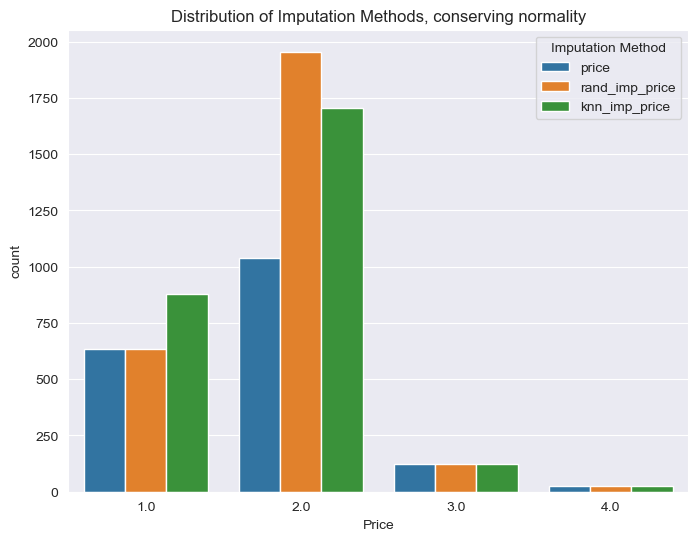

In [18]:
# Visualize Imputation methods
df_melted = df.melt(value_vars=['price', 'rand_imp_price', 'knn_imp_price'],
                    var_name='Imputation Method', value_name='Price')

fig, ax = plt.subplots(1, figsize=(8,6))
sns.countplot(data=df_melted, x='Price', hue='Imputation Method', ax=ax)\
    .set_title('Distribution of Imputation Methods, conserving normality')

fig.savefig('../Images/revised-images/price-imputation-results.png', format='png', dpi=150)

In [19]:
# Check correlation of price vs review and rating counts
# Given the complex nature of NYC's leasing market, I decided to move forward with KNN imputation
# Split into multiple dataframes by price
def split_by_price(df, column):
    prices_dict = {}
    for i in range(0, 4):
        sub_frame = df[df[column] == 1+i]
        # Filter down subframe
        sub_frame = sub_frame[['rating', 'review_count', column]]
        prices_dict[f'price_{1+i}'] = sub_frame
    return prices_dict

# Perform split on knn_imp_price
prices_collection = split_by_price(df, 'knn_imp_price')

In [20]:
# Perform Tukey's 
reviews_for_tukey = pd.concat([df for df in prices_collection.values()], axis=0)
ratings_for_tukey = pd.concat([df for df in prices_collection.values()], axis=0)

rating_tukey = pairwise_tukeyhsd(ratings_for_tukey.rating, ratings_for_tukey.knn_imp_price, 0.05)
review_tukey = pairwise_tukeyhsd(reviews_for_tukey.review_count, reviews_for_tukey.knn_imp_price, 0.05)

print(rating_tukey)
print(review_tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0   0.0594 0.9852 -0.3762   0.495  False
   1.0    3.0  -1.4077 0.0018 -2.4104 -0.4049   True
   1.0    4.0   0.5881 0.8874 -1.4993  2.6755  False
   2.0    3.0   -1.467 0.0006  -2.439 -0.4951   True
   2.0    4.0   0.5287 0.9136  -1.544  2.6015  False
   3.0    4.0   1.9958 0.1056 -0.2652  4.2567  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1.0    2.0   0.2813 0.0007   0.093 0.4697   True
   1.0    3.0   1.5944    0.0  1.1608 2.0279   True
   1.0    4.0   1.3502 0.0007  0.4477 2.2527   True
   2.0    3.0    1.313    0.0  0.8928 1.7333   True
   2.0    4.0   1.0688 0.0118  0.1727  1.965   True
   3.0    4.0  -0.2442 0.9183 -1.2218 0.7334  False
--

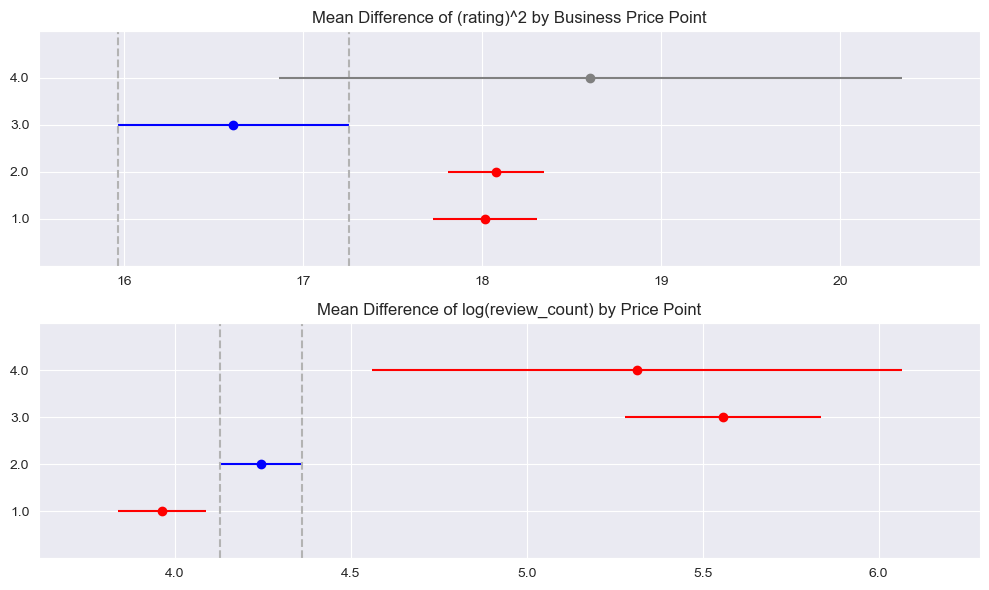

In [21]:
# Plot mean differences
fig, ax = plt.subplots(2,1)
rating_tukey.plot_simultaneous(comparison_name=3.0, ax=ax[0])
review_tukey.plot_simultaneous(comparison_name=2.0, ax=ax[1])


# Set Labels
ax[0].set_title('Mean Difference of (rating)^2 by Business Price Point')
ax[1].set_title('Mean Difference of log(review_count) by Price Point')
fig.tight_layout()

# Export 
fig.savefig('../Images/revised-images/mean_diff_by_price.png', format='png', dpi=150)
fig.show()

# Summary of Mean Diff by Price:
p-val spread of price points indicates that people are generally more critical of businesses that have 4 dollar price points. 

However, it appears 3 dollar sign businesses still draw scruitiny and generally are rated lower than 2 and 1 star. But generally receive more foot traffic based on review count. The difference in review_count between 2 and 3 dollar sign businesses are significant, and I believe is worth investigating.

Based on the spread of rating in 2 and 1 star businesses, suggests that reviewers are less critical of these businesses, however these businesses have significantly lower foot traffic (based on review_count_ compared to 3 and 4 dollar sign businesses

In [22]:
# Begin investigating 'success'. Are there more 'successful' business types than others?
print(f'''
    Review 50th Percentile: {review_metric}
    Rating 50th Percentile: {rating_metric}
    ''')

# Add a 'is_successful' column to dataframe
df['is_successful'] = ((df['review_count'] >= review_metric) & (df['rating'] >= rating_metric)).astype(int)
df['is_successful'].value_counts()


    Review 50th Percentile: 4.394449154672439
    Rating 50th Percentile: 16.0
    


is_successful
0    1573
1    1163
Name: count, dtype: int64

In [23]:
# Question: Is there an association between the category type and its success?
# Chi Contingency
def get_categories(pattern, columns):
        dataframe = df[df[pattern] == 1][columns]
        dataframe['category'] = str(pattern)
        return dataframe

def get_all_categories(pattern_list, target_columns):
    category_dict = {}
    for cat in pattern_list:
        category_dict[cat] = get_categories(cat, target_columns)
    return category_dict

category_dict = get_all_categories(category_groups, ['is_successful'])

In [24]:
# Chi Contingency
# Stack all dataframes
category_successful = pd.concat([df for df in category_dict.values()], axis=0)

# Crosstable
cx_table = pd.crosstab(category_successful.category, category_successful.is_successful)

# Chi2
chi2, pval, dof, expected = chi2_contingency(cx_table)

In [25]:
cx_table

is_successful,0,1
category,,
is_Other,524,479
is_bakeries,754,391
is_bubbletea,73,37
is_cafe,148,116
is_cakeshop,178,69
is_chocolate,23,27
is_cupcakes,93,37
is_desserts,405,251
is_donuts,123,49


In [26]:
# Evaluate chi2
print(f'Chi2 Statistic: {chi2} \n'
      f'p-value: {pval} \n'
      f'Degrees of freedom: {dof}\n')
# Strong support that there is an association between type and success

Chi2 Statistic: 84.46215760088057 
p-value: 2.0890880144698534e-14 
Degrees of freedom: 9


is_successful         0         1
category                         
is_Other      -3.554005  4.445577
is_bakeries    2.098098 -2.624435
is_bubbletea   0.719073 -0.899462
is_cafe       -1.029262  1.287467
is_cakeshop    2.224656 -2.782741
is_chocolate  -1.358710  1.699561
is_cupcakes    1.537106 -1.922711
is_desserts    0.239152 -0.299146
is_donuts      1.763552 -2.205964
is_icecream   -1.413673  1.768312


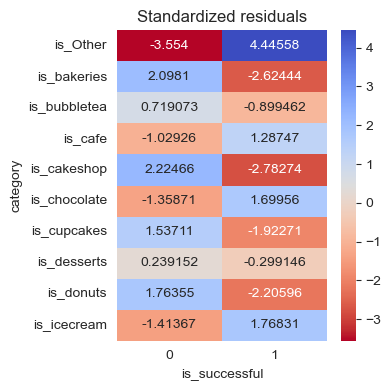

In [27]:
# Heatmap for observed counts
# Process expected into a df
expected = pd.DataFrame(expected, columns=[0, 1], index=cx_table.index)

# Calculate residuals via std residuals
residuals_standardized = (cx_table - expected) / np.sqrt(expected)
print(residuals_standardized)
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.heatmap(residuals_standardized, annot=True, fmt='g', cmap='coolwarm_r', ax=ax)
ax.set_title('Standardized residuals')
plt.tight_layout()
fig.savefig('../Images/revised-images/chi2_residuals.png', format='png', dpi=150)


# Chi2 Summary

Based on the calculated residuals, a negative residual for not successful indicates that this type is more likely to be successful. The larger the magnitude, the less likely and is reinforce by the value in the successful column.

* Other businesses are more likely to be successful than expected by chance
* Bakeries surprisingly are less likely to be successful than by chance **supported by high magnitude**
* Bubble tea is less likely to be successful, but **low magnitude** suggests that success happens by chance
* Cafes are **more** likely to be successful.
* Cakeshops are less likely to be successful, supported by **high magnitude**
* Chocolateshops are **more** like to be successful.
* Desserts are less likely to be successful, but **low magnitude** suggests that success happens by chance
* Donuts are less likely to be successful.
* Ice cream is **more** likely to be successful, supported by **high magnitude**

Bakeries, and cake shops, depending on your perspective, a low success rate may indicate a call for innovation in this business type.



In [28]:
# Save dataframe
df.to_csv('../Resources/post_EDA.csv', index=False)